In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("penguins.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
train = df.sample(frac = 0.7, random_state = 1)
test = df.drop(train.index)

y_train = train["species"]
x_train = train.drop("species", axis = 1)

y_test = test["species"]
x_test = test.drop("species", axis = 1)
print('Dimensiones de datos de prueba', x_test.shape,'\nDimensiones de datos de entrenamiento', x_train.shape)

Dimensiones de datos de prueba (103, 6) 
Dimensiones de datos de entrenamiento (241, 6)


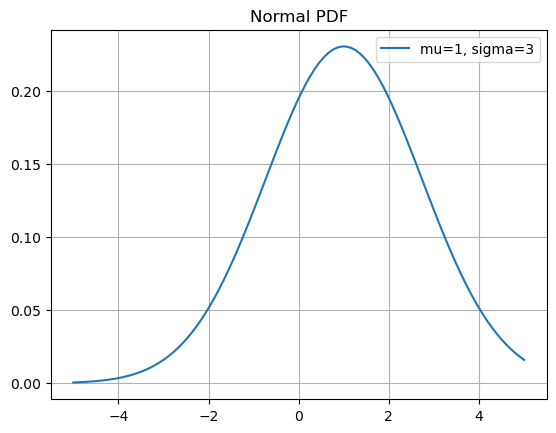

In [5]:
import matplotlib.pyplot as plt

def normalpdf(n, mu=0, sigma=1):
    # Funcion para estimar PDF (Probability Density Function) dado que hay una distribucion Normal(mu, var) evaluado con x
    sd = np.sqrt(sigma)
    pdf = (np.e ** (-0.5 * ((n - mu)/sd) ** 2)) / (sd * np.sqrt(2 * np.pi))
    return pdf


# Define the parameters of the Gaussian function
mu = 1  # mean
sigma = 3  # standard deviation

xs = np.linspace(-5, 5, 100)
ys = normalpdf(xs, mu, sigma)

# Generate plot
plt.title('Normal PDF')
plt.plot(xs, ys, label = 'mu='+str(mu)+', sigma='+str(sigma))
plt.legend() # incluir label
plt.grid(True)
plt.show()

In [6]:
# Exclude non-numeric columns before applying aggregation functions
numeric_columns = train.select_dtypes(include=[np.number]).columns

means = train.groupby(["species"])[numeric_columns].mean()  # Estimacion de la media de cada clase, por característica
var = train.groupby(["species"])[numeric_columns].var()  # Estimacion de la varianza de cada clase, por característica
prior = train["species"].value_counts() / len(train)  # Estimacion probabilidades a priori P(C)
clases = np.unique(train["species"].tolist())  # Todas las clases posibles

print('Estimacion de la media de cada clase, por característica:\n', means)
print('\nEstimacion de la varianza de cada clase, por característica\n', var)
print('\nEstimacion probabilidades a priori\n', prior)

Estimacion de la media de cada clase, por característica:
            bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
species                                                                 
Adelie          38.717647      18.365686         189.715686  3676.225490
Chinstrap       48.622642      18.349057         195.433962  3756.603774
Gentoo          47.125581      14.947674         217.151163  5058.430233

Estimacion de la varianza de cada clase, por característica
            bill_length_mm  bill_depth_mm  flipper_length_mm    body_mass_g
species                                                                   
Adelie           7.469388       1.578514          46.264900  205165.562512
Chinstrap       10.857170       1.253701          55.519594  147046.897678
Gentoo           8.271808       0.954524          39.023940  230832.506840

Estimacion probabilidades a priori
 species
Adelie       0.423237
Gentoo       0.356846
Chinstrap    0.219917
Name: count, dtype: float64


In [7]:
def predict(X):
    predictions = []

    for i in X.index:  # Loop through each instance

        ClassLikelihood = []
        instance = X.loc[i]

        for cls in clases:  # Loop through each class

            FeatureLikelihoods = []
            FeatureLikelihoods.append(np.log(prior[cls]))  # Append log prior of class 'cls'

            for col in x_train.columns:  # Loop through each feature

                data = instance[col]

                # Handle missing values
                if pd.isna(data):
                    Likelihood = 1e-10  # Assign a very small likelihood for missing values
                else:
                    mean = means[col].loc[cls]  # Find the mean of column 'col' that are in class 'cls'
                    variance = var[col].loc[cls]  # Find the variance of column 'col' that are in class 'cls'

                    # Handle zero variance
                    if variance == 0:
                        variance = 1e-10  # Assign a very small variance to avoid division by zero

                    Likelihood = normalpdf(data, mean, variance)

                # Handle zero likelihood
                if Likelihood != 0:
                    Likelihood = np.log(Likelihood)  # Find the log-likelihood evaluated at x
                else:
                    Likelihood = -1e10  # Assign a very small log-likelihood for zero likelihood

                FeatureLikelihoods.append(Likelihood)

            TotalLikelihood = sum(FeatureLikelihoods)  # Calculate posterior
            ClassLikelihood.append(TotalLikelihood)

        MaxIndex = ClassLikelihood.index(max(ClassLikelihood))  # Find largest posterior position
        prediction = clases[MaxIndex]
        predictions.append(prediction)

    return predictions

In [8]:
PredictTrain = predict(x_train)
PredictTest = predict(x_test)

# Despliega su precisión
print('Training set Accuracy: ',round(100*sum(PredictTrain==y_train) / len(y_train),3),'%')
print('Testing set Accuracy: ',round(100*sum(PredictTest==y_test) / len(y_test),3),'%')

KeyError: 'island'